# Temporal Regression with LightGBM

Data preprocessing:
1. Categorical features have been Encoded
2. Text columns and columns that have no effect on the model have been dropped
3. Added 7 lagged values

Model trainig:
1. Trained a LightGBM model using GridSearchCV

Results:
1. Model performance
- MAE: 38.34
- MSE: 2684.70
- MAPE: 0.055
- RMSE: 51.81
2. Included plot of the most important features

### Import modules

In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [381]:
df = pd.read_csv('daily crime numbers and weather data for time series analysis.csv', index_col='date', parse_dates=['date'])
df.shape

(4960, 73)

In [382]:
df.columns

Index(['Kidnapping/Abduction', 'Sex Offenses, Forcible', 'Robbery',
       'Assault Offenses', 'Arson', 'Extortion/Blackmail',
       'Burglary/Breaking & Entering', 'Larceny/Theft Offenses',
       'Motor Vehicle Theft', 'Counterfeiting/Forgery', 'Fraud Offenses',
       'Embezzlement', 'Stolen Property Offenses',
       'Destruction/Damage/Vandalism of Property', 'Drug/Narcotic Offenses',
       'Sex Offenses, Nonforcible', 'Pornography/Obscene Material',
       'Gambling Offenses', 'Prostitution Offenses', 'Bribery',
       'Weapon Law Violations', 'Human Trafficking or Kidnapping/Abduction',
       'Animal Cruelty', 'Homicide Offenses', 'Bad Checks',
       'Curfew/Loitering/Vagrancy Violations', 'Disorderly Conduct',
       'Driving Under the Influence', 'Drunkenness',
       'Family Offenses, Nonviolent', 'Liquor Law Violations', 'Peeping Tom',
       'Runaway', 'Trespass of Real Property', 'All Other Offenses',
       'Offense Count', 'week', 'month', 'year', 'mon_year', 'season

In [383]:
def visualize_time_series(column, graph_title, graph_ylabel):
    fig, ax = plt.subplots(figsize=(15, 4))

    df.plot(y=column, ax=ax, label='Dataset', title=graph_title, linewidth=1)

    plt.xlabel("Date")
    plt.ylabel(graph_ylabel)
    plt.show()

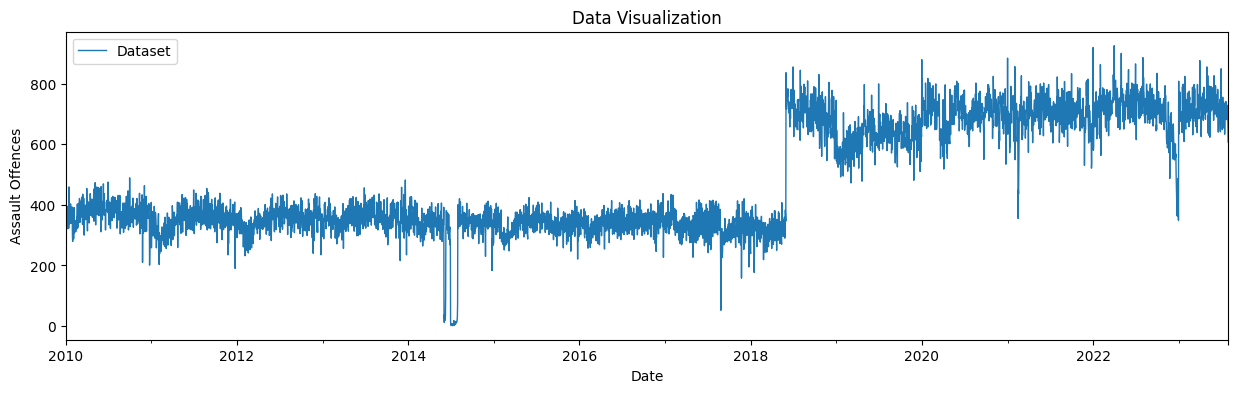

In [384]:
visualize_time_series('Offense Count', 'Data Visualization', 'Assault Offences')

## Feature engineering

In [385]:
# null values
counts = df.isnull().sum()
print(counts.sort_values(ascending=False))

solarenergy                                  365
solarradiation                               365
uvindex                                      365
precip                                         0
humidity                                       0
                                            ... 
Bad Checks                                     0
Homicide Offenses                              0
Animal Cruelty                                 0
Human Trafficking or Kidnapping/Abduction      0
stations                                       0
Length: 73, dtype: int64


A full year (2015) worth of data is missing for solarenergy, solarradiation, and uvindex

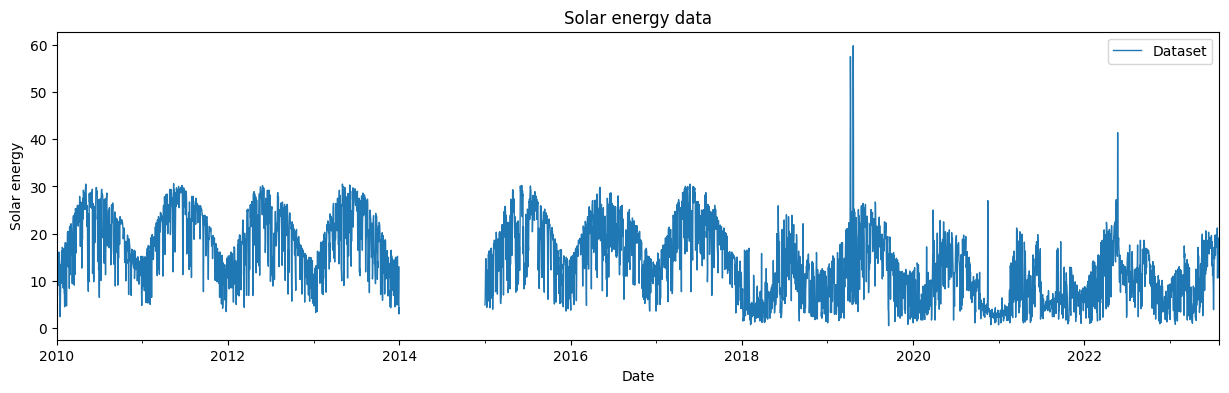

In [386]:
visualize_time_series('solarenergy', 'Solar energy data', 'Solar energy')

In [387]:
# Fill missing data with values from the previous year
df = df.fillna(df.shift(365))

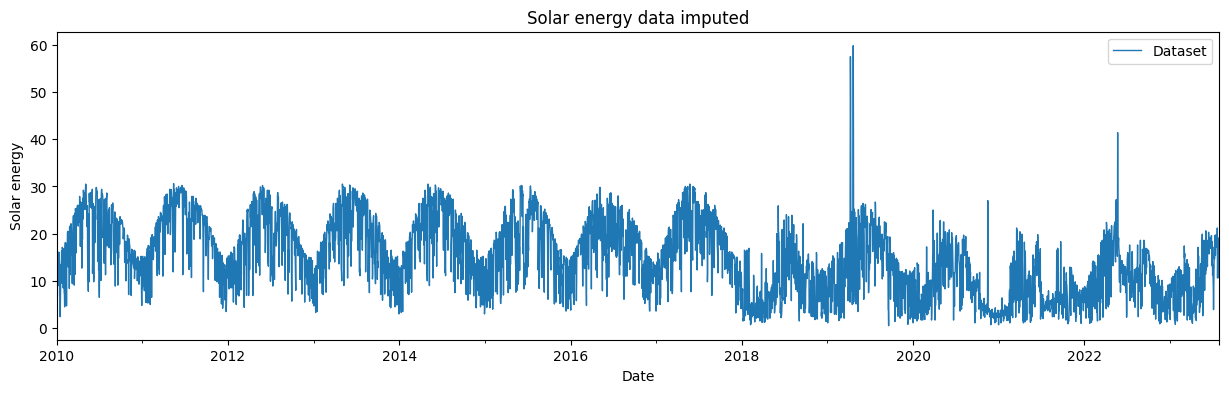

In [388]:
visualize_time_series('solarenergy', 'Solar energy data imputed', 'Solar energy')

In [389]:
# using sunrise and sunset to create daytime
# resulted in obtaining worse results
# df['daytime'] = ((pd.to_datetime(df['sunset'])-pd.to_datetime(df['sunrise'])).dt.total_seconds() / 60).astype(int)

Time series are characterized by the time-related dependenceies between values. To make use of this aspect in our model we will integrate a number of past values of the target variable as input features. We 7 of the most recent past values as this captures most of the past data information.

In [390]:
def create_lag_features(df, lags=2):
  y = df.loc[:, 'Offense Count']
  for lag in range(lags):
    df[f"lag_{lag + 1}"] = y.shift(lag + 1)
  return df

df = create_lag_features(df, lags=7)

- Encode categorical data
- Drop text columns and columns that have no impact on the model

In [391]:
from sklearn.preprocessing import LabelEncoder

# "OneHotEncode" categorial fetures
def encodeCategoricalFeatures(main_df):
    df = main_df.copy()

    columns = ["week", "season", "icon", "preciptype", "conditions"]

    dummies = pd.get_dummies(df[columns])
    df = pd.concat([df, dummies], axis='columns')
    
    return df

# drop cols
def dropFeatures(main_df):
    df = main_df.copy()
    cols = [
        'week',
        'season',
        'icon',
        'mon_year',
        'preciptype',
        'conditions',
        'sunrise',
        'sunset',
        'conditions',
        'description',
        'stations',
        'snow',
        'snowdepth',
        'precipprob',
    ]
    df.drop(columns=cols, inplace=True)
    return df

In [392]:
df = (df
      .pipe(encodeCategoricalFeatures)
      .pipe(dropFeatures)
)

### Train / test split

In [393]:
# Split df_final into train and test
num_train = int(len(df)*0.8)

train = df[:num_train]
test = df[num_train:]

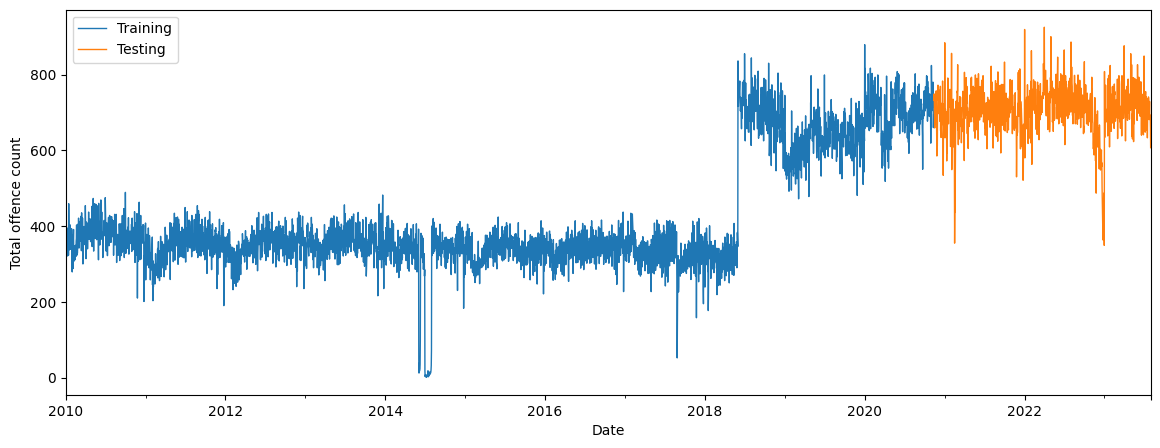

In [394]:
figure, ax = plt.subplots(figsize=(14, 5))
train.plot(ax=ax, label="Training", y="Offense Count", linewidth=1)
test.plot(ax=ax, label="Testing", y="Offense Count", linewidth=1)
plt.xlabel("Date")
plt.ylabel("Total offence count")
plt.show()

In [395]:
y_train_all = train.iloc[:, :36]
y_test_all = test.iloc[:, :36]

train = train.iloc[:, 36:]
test = test.iloc[:, 36:]

X_train = train.values
X_test = test.values

In [396]:
# pick one target value
y_train = y_train_all['Offense Count'].values
y_test = y_test_all['Offense Count'].values

## LightGB Model

### Training

In [397]:
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# LGBM
cv_split = TimeSeriesSplit(n_splits=4, test_size=100)
model = lgb.LGBMRegressor()
parameters = {
    "max_depth": [3, 4, 5, 6],
    "num_leaves": [10, 20, 30, 40],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "n_estimators": [50, 100],
    "colsample_bytree": [0.5, 0.7, 1]

    # "max_depth": [4],
    # "num_leaves": [20],
    # "learning_rate": [0.1],
    # "n_estimators": [50, 80, 100],
    # "colsample_bytree": [1]
}

grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=100),
             estimator=LGBMRegressor(),
             param_grid={'colsample_bytree': [0.5, 0.7, 1],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 6], 'n_estimators': [50, 100],
                         'num_leaves': [10, 20, 30, 40]})

### Evaluation

In [398]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, pred):
  print(f"MAE: {mean_absolute_error(y_test, pred)}")
  print(f"MSE: {mean_squared_error(y_test, pred)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, pred)}")
  print(f"RMSE: {np.sqrt(mean_squared_error(y_test, pred))}")
  
def plot_predictions(title, ax, testing_dates, y_test, pred):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": pred })
  df_test.plot(ax=ax, label="Actual", x="date", y="actual", linewidth=2)
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction", linewidth=2)
  plt.legend(["Actual", "Prediction"])
  ax.set_title(title)
  # plt.show()

MAE: 37.87954690827618
MSE: 2709.250237625984
MAPE: 0.0543210485552397
RMSE: 52.05045857267719


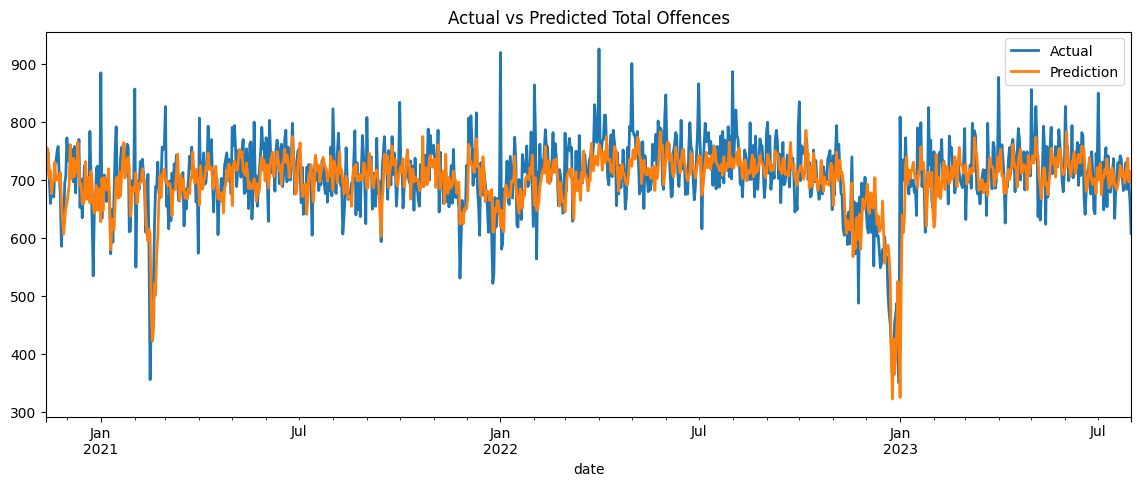

In [399]:
# Evaluating GridSearch results
pred = grid_search.predict(X_test)
figure, ax = plt.subplots(figsize=(14, 5))
plot_predictions("Actual vs Predicted Total Offences", ax, test.index, y_test, pred)
evaluate_model(y_test, pred)

### Explain predictions

In [400]:
import shap

# compute SHAP values
explainer = shap.Explainer(grid_search.best_estimator_, train)
shap_values = explainer(train)

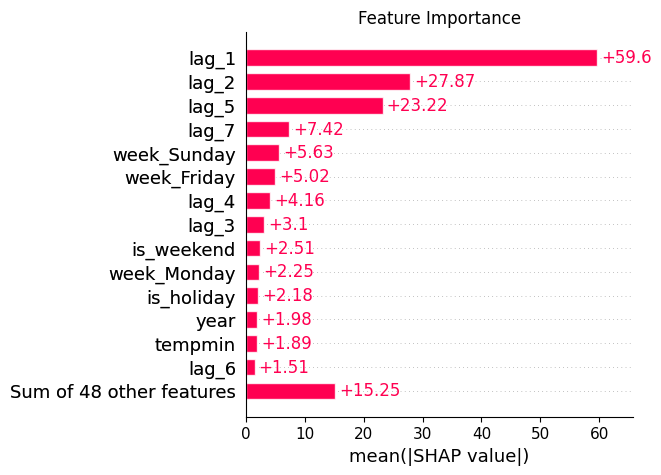

In [401]:
# most important features computed and plotted using the SHAP library
shap.plots.bar(shap_values, max_display=15, show=False)

plt.title('Feature Importance')
plt.gcf().set_size_inches(5,5)
plt.show()

In [402]:
def plot_feature_importance(df_feat_imp):
    df_feat_imp = df_feat_imp.T.sort_values(0)

    ax = df_feat_imp.tail(15).plot(kind='barh', figsize=(6, 6), width=.7, color="#008BFB")
    ax.set_title("Feature Importance (%)")
    ax.bar_label(ax.containers[0], padding=5)
    ax.legend().remove()

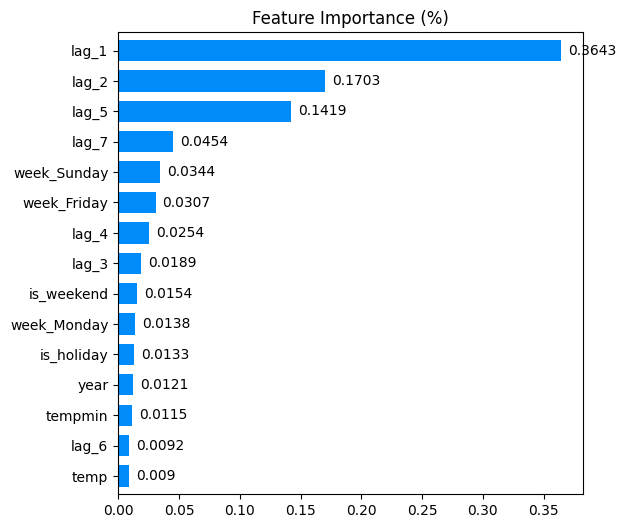

In [403]:
# compute feature imporance as a percentage
feature_importance = abs(shap_values.values).sum(axis=0) / abs(shap_values.values).sum()
feature_names = train.columns
df_feat_imp = pd.DataFrame([np.round(feature_importance, 4)], columns=feature_names)

plot_feature_importance(df_feat_imp)

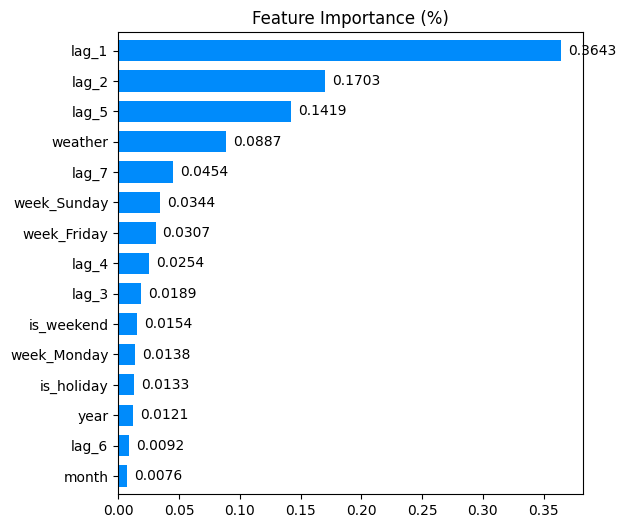

In [404]:
# group together weather features
weather_features = ['tempmax', 'tempmin',
       'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipcover', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'moonphase']

df_feat_imp['weather_1'] = df_feat_imp[weather_features].sum(axis=1)
df_feat_imp.drop(columns=weather_features, inplace=True)

df_feat_imp['weather_2'] = df_feat_imp[[col for col in df_feat_imp.columns if 
                                        (col.startswith('icon_') or col.startswith('preciptype_') or col.startswith('conditions_'))
                                        ]].sum(axis=1)
df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('icon_')]
df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('preciptype_')]
df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('conditions_')]

df_feat_imp['weather'] = df_feat_imp[[col for col in df_feat_imp.columns if col.startswith('weather_')]].sum(axis=1)
df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('weather_')]

plot_feature_importance(df_feat_imp)

## Analysis of different offense types and how weather affects them

Consider the top 8 crime types by count, for better consistancy.

In [405]:
top_offenses_by_count = y_train_all.sum(axis=0).sort_values(ascending=False)
top_offenses_by_count.drop(labels=['Offense Count', 'All Other Offenses'], inplace=True)
top_offenses_by_count = top_offenses_by_count[:8]

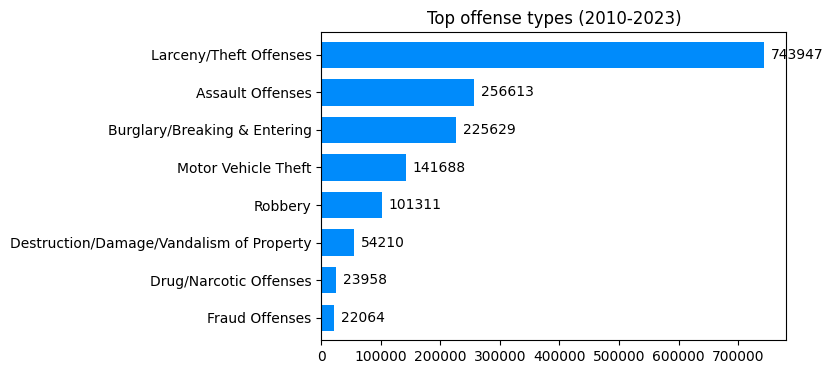

In [406]:
# display top offenses
ax = top_offenses_by_count.sort_values().plot(kind='barh', figsize=(6, 4), width=.7, color="#008BFB")
ax.set_title("Top offense types (2010-2023)")
ax.bar_label(ax.containers[0], padding=5)
plt.show()

### Compute how weather conditions affect each of the top offenses

In [407]:
# compute how weather factors affect different offenses
weather_importance_by_offence = {}
pred_by_offence = {}
feature_importance_all = {}
feature_importance_weather = {}

for offense, _ in top_offenses_by_count.items():
    # pick one target value
    y_train = y_train_all[offense].values
    y_test = y_test_all[offense].values

    # train model
    model = lgb.LGBMRegressor()
    parameters = {
        "max_depth": [3, 4, 5],
        "num_leaves": [10, 20, 30],
        "learning_rate": [0.01, 0.05, 0.1, 0.2],
        "n_estimators": [50, 100],
        "colsample_bytree": [0.5, 0.7, 1]
    }
    grid_search = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
    grid_search.fit(X_train, y_train)

    # save preditions
    pred_by_offence[offense] = grid_search.predict(X_test)

    # compute SHAP values
    explainer = shap.Explainer(grid_search.best_estimator_, train)
    shap_values = explainer(train)

    # compute feature imporance as a percentage
    feature_importance = abs(shap_values.values).sum(axis=0) / abs(shap_values.values).sum()
    feature_names = train.columns
    df_feat_imp = pd.DataFrame([np.round(feature_importance, 4)], columns=feature_names)

    feature_importance_all[offense] = df_feat_imp.copy()

    # group together weather features
    weather_features = ['tempmax', 'tempmin',
        'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
        'precip', 'precipcover', 'windgust', 'windspeed', 'winddir',
        'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
        'solarenergy', 'uvindex', 'moonphase']

    df_feat_imp['weather_1'] = df_feat_imp[weather_features].sum(axis=1)
    df_feat_imp.drop(columns=weather_features, inplace=True)

    df_feat_imp['weather_2'] = df_feat_imp[[col for col in df_feat_imp.columns if 
                                            (col.startswith('icon_') or col.startswith('preciptype_') or col.startswith('conditions_'))
                                            ]].sum(axis=1)
    df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('icon_')]
    df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('preciptype_')]
    df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('conditions_')]

    df_feat_imp['weather'] = df_feat_imp[[col for col in df_feat_imp.columns if col.startswith('weather_')]].sum(axis=1)
    df_feat_imp = df_feat_imp.loc[:, ~df_feat_imp.columns.str.startswith('weather_')]

    # save feature importance
    feature_importance_weather[offense] = df_feat_imp.copy()

    weather_importance_by_offence[offense] = df_feat_imp['weather'][0]

 98%|===================| 3869/3968 [00:14<00:00]        

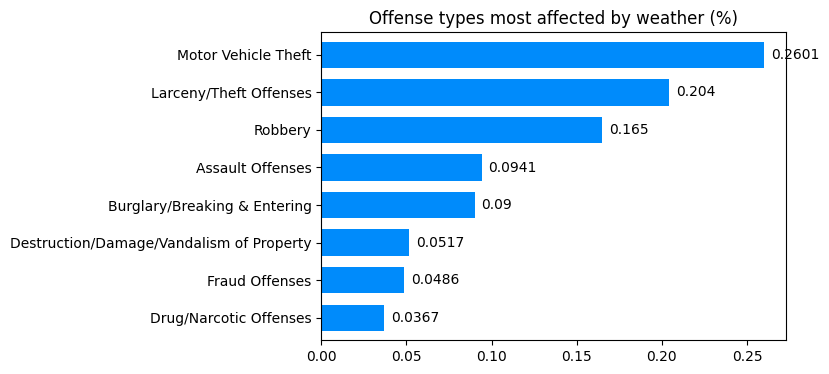

In [408]:
# display offenses most affected by weather
ax = pd.DataFrame.from_dict([weather_importance_by_offence]).T.sort_values(0).plot(kind='barh', figsize=(6, 4), width=.7, color="#008BFB")
ax.set_title("Offense types most affected by weather (%)")
ax.bar_label(ax.containers[0], padding=5)
ax.legend().remove()
plt.show()

### Actual vs Predicted values for the Top Offenses

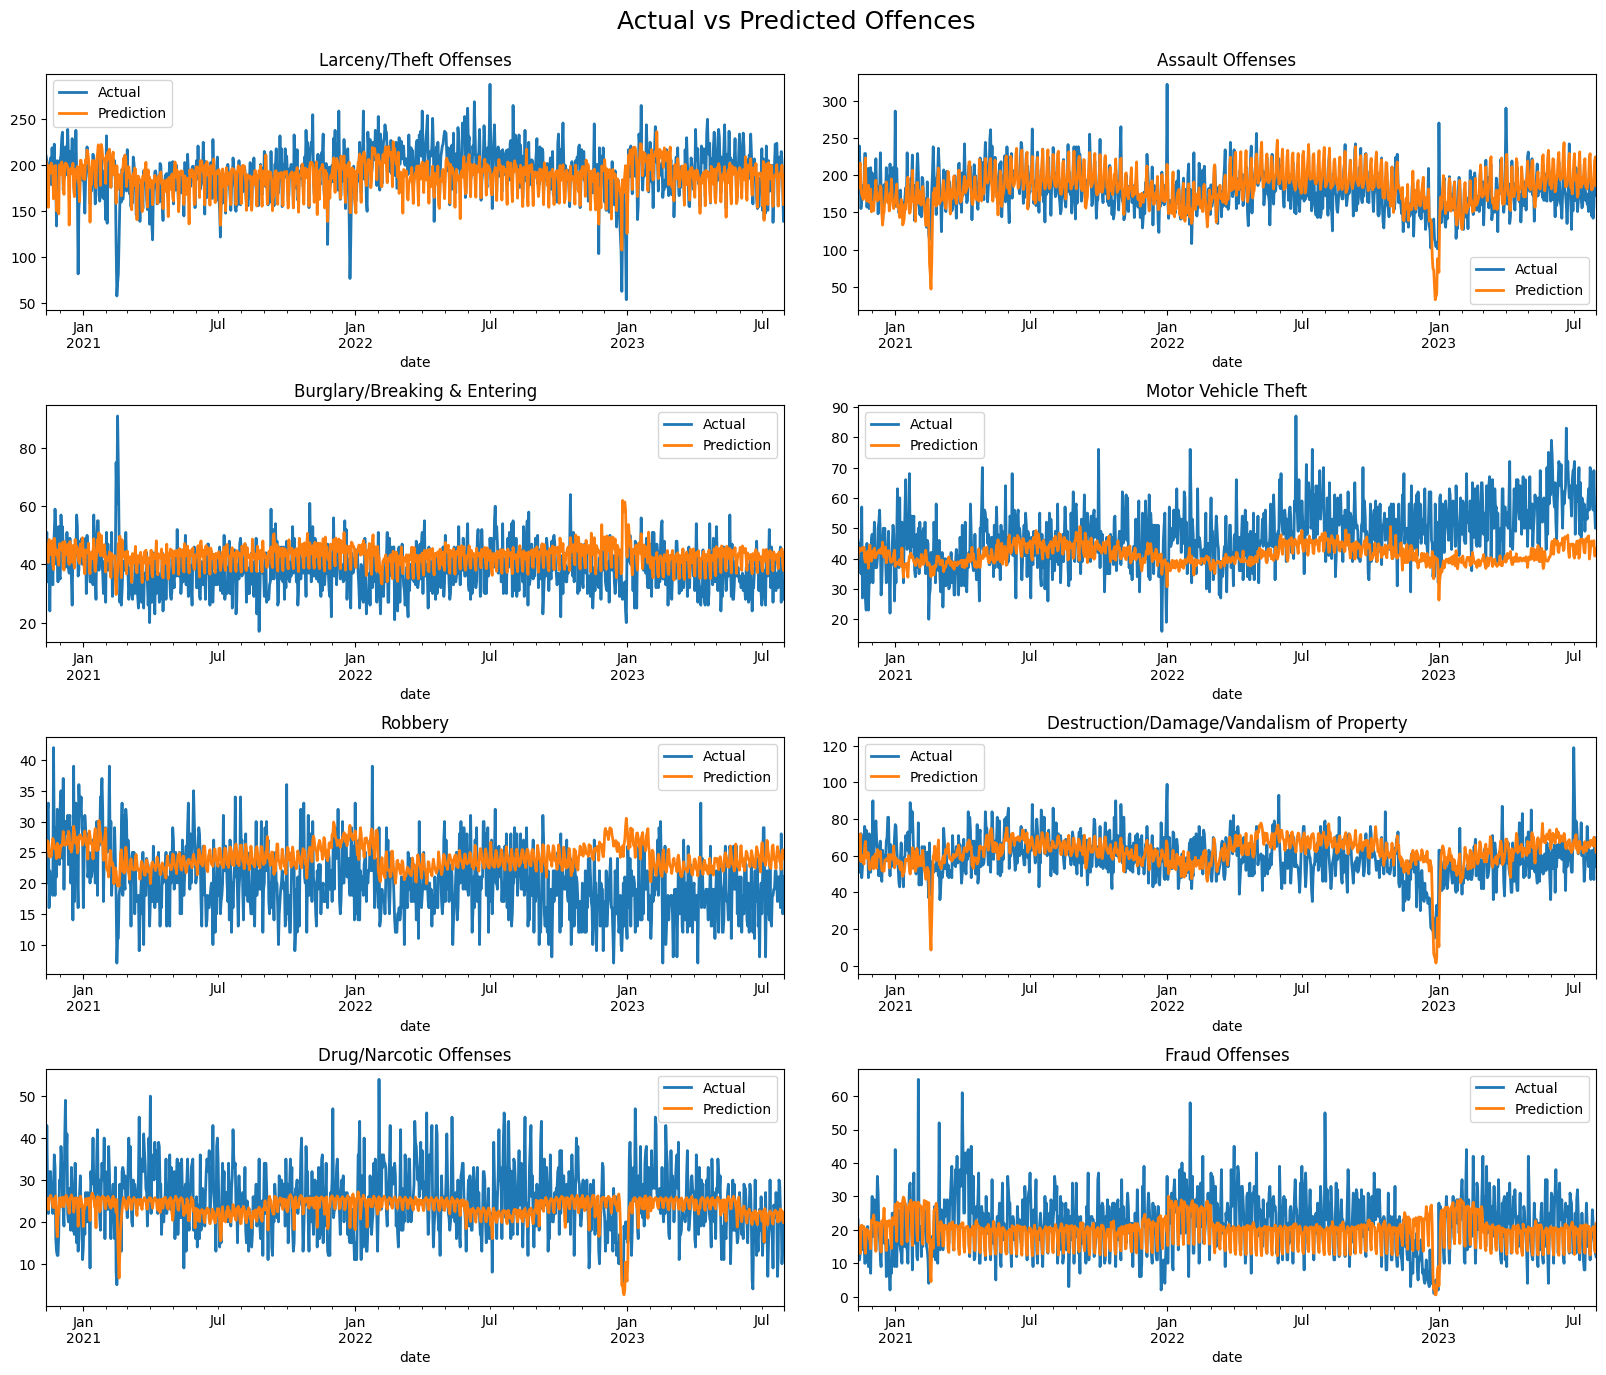

In [409]:
# plot predicted values for the top offenses
nrow = 4
ncol = 2
fig, axs = plt.subplots(nrow, ncol, figsize=(20, 16))
plt.subplots_adjust(hspace=0.4, wspace=.1)
fig.suptitle("Actual vs Predicted Offences", fontsize=18, y=0.92)

i=0
for offense, _ in top_offenses_by_count.items():
    pred = pred_by_offence[offense]
    y_test = y_test_all[offense].values
    plot_predictions(offense, fig.axes[i], test.index, y_test, pred)
    i+=1

plt.show()

### Feature importance breakdown for the Top Offenses

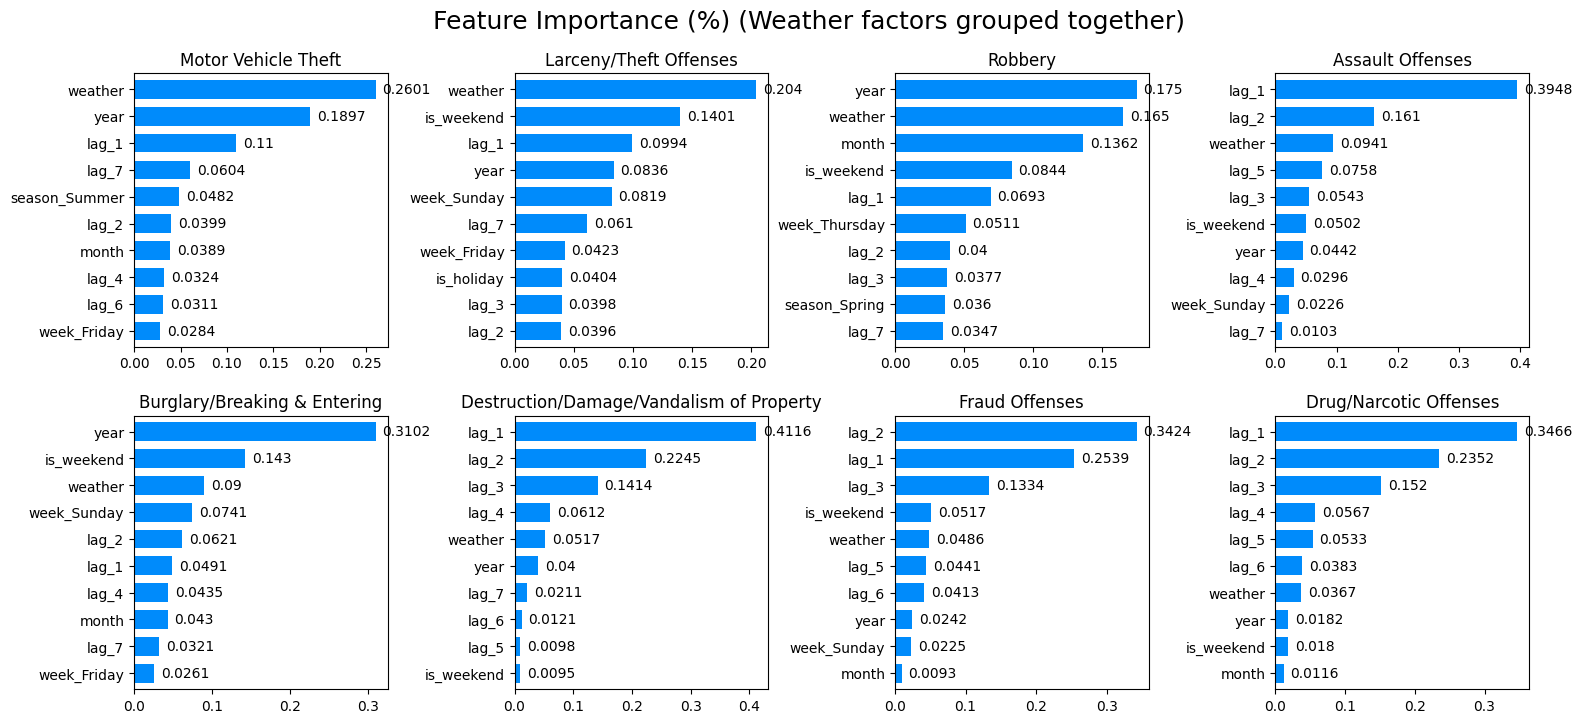

In [416]:
# plot most important features (having weather conditions grouped together) for the top offenses
nrow = 2
ncol = 4
fig, axs = plt.subplots(nrow, ncol, figsize=(18, 8))
plt.subplots_adjust(hspace=0.25, wspace=.5)
fig.suptitle("Feature Importance (%) (Weather factors grouped together)", fontsize=18, y=0.96)

i=0
for offense, _ in dict(sorted(weather_importance_by_offence.items(), key=lambda x:x[1], reverse=True)).items():
    
    df_feat_imp = feature_importance_weather[offense].T.sort_values(0)
    ax = df_feat_imp.tail(10).plot(kind='barh', ax=fig.axes[i], width=.7, color="#008BFB")
    ax.set_title(offense)
    ax.bar_label(ax.containers[0], padding=5)
    ax.legend().remove()
    i+=1

plt.show()

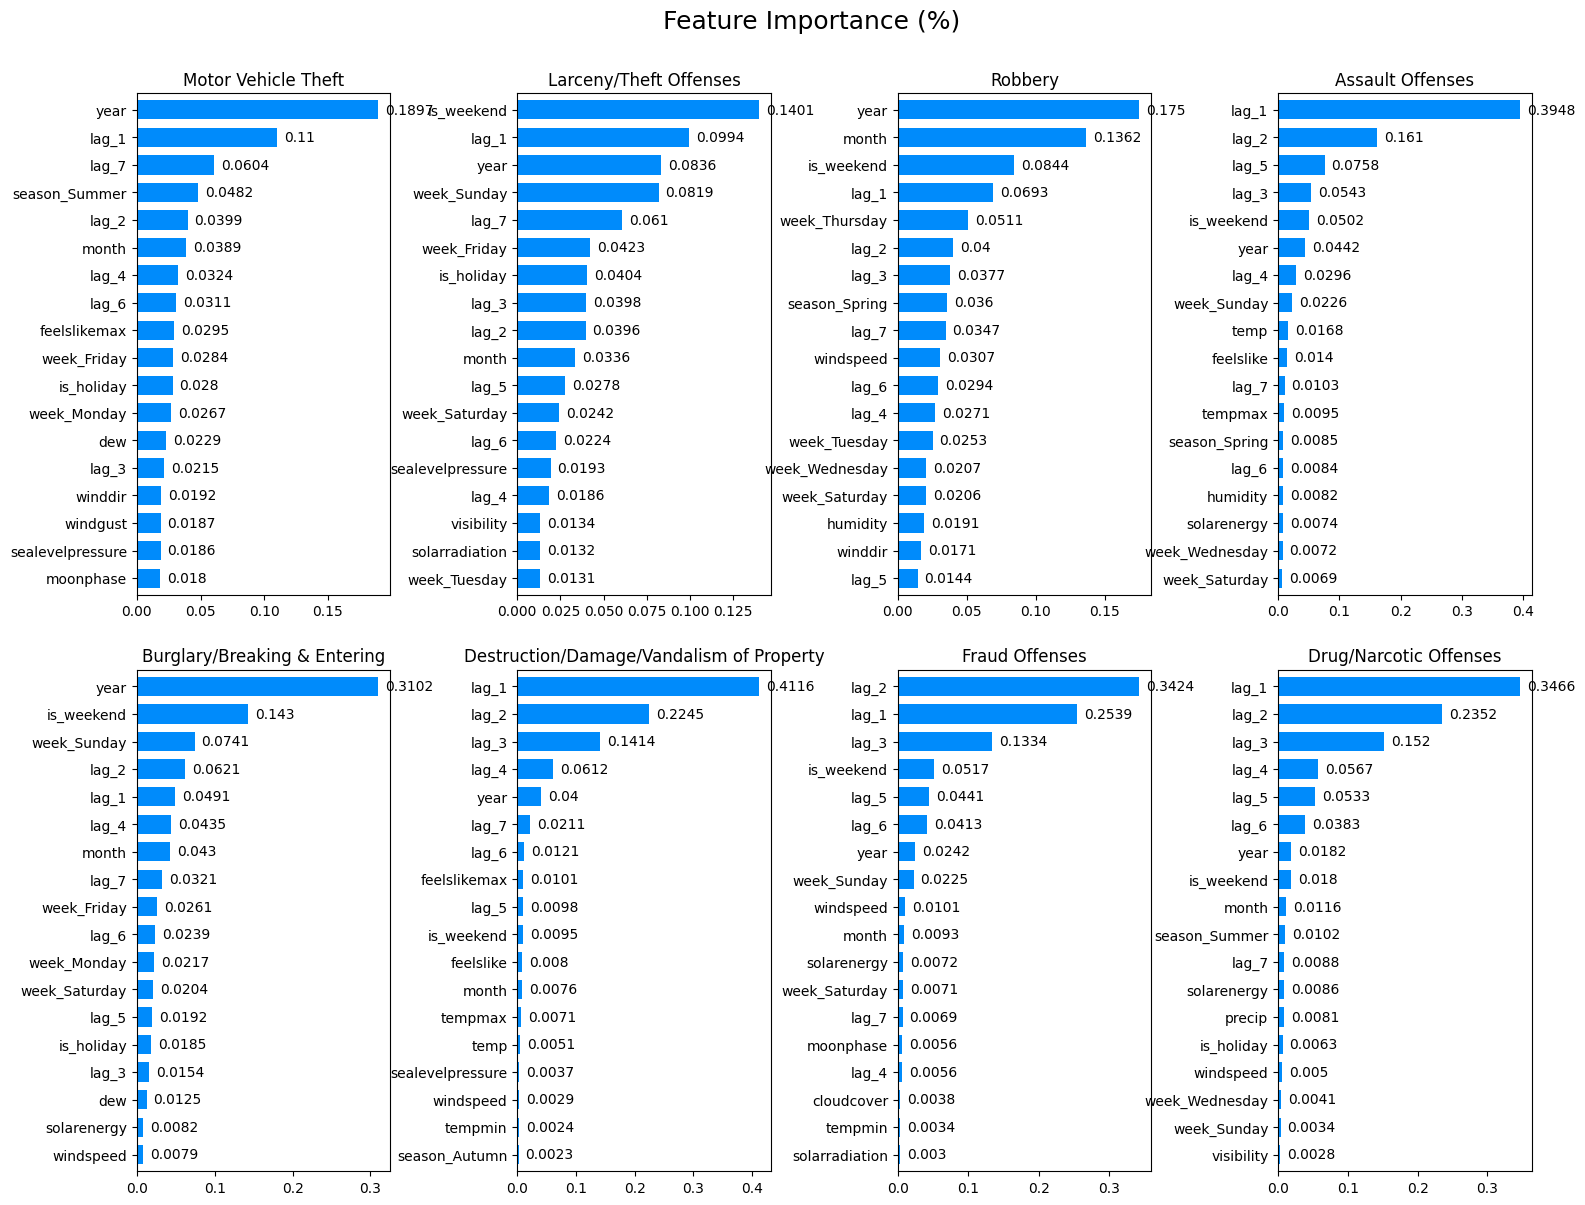

In [417]:
# plot most important features (having weather conditions grouped together) for the top offenses
nrow = 2
ncol = 4
fig, axs = plt.subplots(nrow, ncol, figsize=(18, 14))
plt.subplots_adjust(hspace=0.15, wspace=.5)
fig.suptitle("Feature Importance (%)", fontsize=18, y=0.94)

i=0
for offense, _ in dict(sorted(weather_importance_by_offence.items(), key=lambda x:x[1], reverse=True)).items():
    
    df_feat_imp = feature_importance_all[offense].T.sort_values(0)
    ax = df_feat_imp.tail(18).plot(kind='barh', ax=fig.axes[i], width=.7, color="#008BFB")
    ax.set_title(offense)
    ax.bar_label(ax.containers[0], padding=5)
    ax.legend().remove()
    i+=1

plt.show()